
# The importance of space
Agent based models are useful when the aggregate system behavior emerges out of local interactions amongst the agents. In the model of the evolution of cooperation, we created a set of agents and let all agents play against all other agents. Basically, we pretended as if all our agents were perfectly mixed. In practice, however, it is much more common that agents only interact with some, but not all, other agents. For example, in models of epidemiology, social interactions are a key factors. Thus, interactions are dependend on your social network. In other situations, our behavior might be based on what we see around us. Phenomena like fashion are at least partly driven by seeing what others are doing and mimicking this behavior. The same is true for many animals. Flocking dynamics as exhibited by starling, or shoaling behavior in fish, can be explained by the animal looking at its neirest neighbors and staying within a given distance of them. In agent based models, anything that structures the interaction amongst agents is typically called a space. This space can be a 2d or 3d space with euclidian distances (as in models of flocking and shoaling), it can also be a grid structure (as we will show below), or it can be a network structure. 

MESA comes with several spaces that we can readily use. These are

* **SingleGrid;** an 'excel-like' space with each agent occopying a single grid cell
* **MultiGrid;** like grid, but with more than one agent per grid cell
* **HexSingleGrid;** like SingleGrid, but on a hexagonal grid (*e.g.*, the board game Catan) thus changing who your neighbours are
* **HexMultiGrid;** like MultiGrid, but on a hexagonal grid (*e.g.*, the board game Catan) thus changing who your neighbours are
* **ConinuousSpace;** a 2d continous space were agents can occupy any coordinate
* **NetworkGrid;** a network structure were one or more agents occupy a given node.

A key concern when using a none-networked space, is to think carefull about what happens at the edges of the space. In a basic implementation, agents in for example the top left corner has only 2 neighbors, while an agent in the middle has four neighbors. This can give rise to artifacts in the results. Basically, the dynamics at the edges are different from the behavior further away from the edges. It is therefore quite common to use a torus, or donut, shape for the space. In this way, there is no longer any edge and artifacts are thus removed.


# The emergence of cooperation in space
The documentation of MESA on the different spaces is quite limited. Therefore, this assignment is largely a tutorial continuing on the evolution of cooperation. 

We make the following changes to the model

* Each agent gets a position, which is an x,y coordinate indicating the grid cell the agent occupies
* The model has a grid, with an agent of random class. We initialize the model with equal probabilities for each type of class
* All agents play against their neighbors. On a grid, neighborhood can be defined in various ways. Below, we use a neighborhood distance of 1, and we do include diagonal neighbors.
* The evolutionary dynamic, after all agents having played, is that each agent compares its scores to its neighbors. It will adopt whichever strategy within its neighborhood performed best.
* Next to using a Grid from MESA, we also use a DataCollector to handle collecting statistics.

Below, I discuss in more detail the code containing the most important modifications


In [1]:
from collections import deque, Counter, defaultdict
from enum import Enum
from itertools import combinations
from math import floor

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from mesa import Model, Agent
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
from mesa.time import BaseScheduler


class Move(Enum):
    COOPERATE = 1
    DEFECT = 2


class AxelrodAgent(Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, pos, model):
        super().__init__(unique_id, model)
        self.points = 0
        self.pos = pos

    def step(self):
        """
        the move and any logic for deciding
        on the move goes here

        Returns
        -------
        Move.COOPERATE or Move.DEFECT

        """
        raise NotImplemetedError

    def receive_payoff(self, payoff, my_move, opponent_move):
        """

        Parameters
        ----------
        payoff : int
        my_move : {Move.COOPERATE, Move.DEFECT}
        opponements_move : {Move.COOPERATE, Move.DEFECT}

        """
        self.points += payoff

    def reset(self):
        """
        called after playing N iterations agains
        another player
        """
        raise NotImplementedError


class TitForTat(AxelrodAgent):
    def __init__(self, unique_id, pos, model):
        super().__init__(unique_id, pos, model)
        self.opponent_last_move = Move.COOPERATE

    def step(self):
        return self.opponent_last_move

    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        self.opponent_last_move = opponent_move

    def reset(self):
        self.opponent_last_move = Move.COOPERATE


class ContriteTitForTat(AxelrodAgent):
    def __init__(self, unique_id, pos, model):
        super().__init__(unique_id, pos, model)
        self.opponent_last_two_moves = deque([Move.COOPERATE, Move.COOPERATE], maxlen=2)

    def step(self):
        if (self.opponent_last_two_moves[0] == Move.DEFECT) and (
            self.opponent_last_two_moves[1] == Move.DEFECT
        ):
            return Move.DEFECT
        else:
            return Move.COOPERATE

    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        self.opponent_last_two_moves.append(opponent_move)

    def reset(self):
        self.opponent_last_two_moves = deque([Move.COOPERATE, Move.COOPERATE], maxlen=2)


class AxelrodScheduler(BaseScheduler):
    def step(self):
        for (agent_a, pos) in self.model.grid.coord_iter():
            for agent_b in self.model.grid.iter_neighbors(pos, moore=True):
                for _ in range(self.model.num_iterations):
                    move_a = agent_a.step()
                    move_b = agent_b.step()

                    # insert noise in movement
                    if self.model.random.random() < self.model.noise_level:
                        if move_a == Move.COOPERATE:
                            move_a = Move.DEFECT
                        else:
                            move_a = Move.COOPERATE
                    if self.model.random.random() < self.model.noise_level:
                        if move_b == Move.COOPERATE:
                            move_b = Move.DEFECT
                        else:
                            move_b = Move.COOPERATE

                    payoff_a, payoff_b = self.model.payoff_matrix[(move_a, move_b)]

                    agent_a.receive_payoff(payoff_a, move_a, move_b)
                    agent_b.receive_payoff(payoff_b, move_b, move_a)
                agent_a.reset()
                agent_b.reset()
                
        self.steps += 1
        self.time += 1
        

class NoisySpatialEvolutionaryAxelrodModel(Model):
    def __init__(
        self,
        N,
        noise_level=0.01,
        seed=None,
        height=20,
        width=20,
    ):
        super().__init__(seed=seed)
        self.noise_level = noise_level
        self.num_iterations = N
        self.agents = set()

        # standard attributes expected by MESA
        self.grid = SingleGrid(width, height, torus=True)
        self.schedule = AxelrodScheduler(self)
        self.running = True
        
        
        self.payoff_matrix = {}
        self.payoff_matrix[(Move.COOPERATE, Move.COOPERATE)] = (2, 2)
        self.payoff_matrix[(Move.COOPERATE, Move.DEFECT)] = (0, 3)
        self.payoff_matrix[(Move.DEFECT, Move.COOPERATE)] = (3, 0)
        self.payoff_matrix[(Move.DEFECT, Move.DEFECT)] = (1, 1)



        strategies = AxelrodAgent.__subclasses__()
        num_strategies = len(strategies)
        self.agent_id = 0

        for cell in self.grid.coord_iter():
            _, pos = cell

            self.agent_id += 1

            strategy_index = int(floor(self.random.random() * num_strategies))

            agent = strategies[strategy_index](self.agent_id, pos, self)
            self.grid.place_agent(agent, pos)
            self.agents.add(agent)

        # also needed by MESA, and useful for tracking the number of agents for each strategy
        self.datacollector = DataCollector(
            model_reporters={klass.__name__: klass.__name__ for klass in strategies}
        )

    def count_agent_types(self):
        counter = Counter()
        for agent in self.agents:
            counter[agent.__class__.__name__] += 1

        for k, v in counter.items():
            setattr(self, k, v)

    def step(self):
        """Advance the model by one step."""
        self.count_agent_types()
        self.datacollector.collect(self)
        self.schedule.step()

        # evolution
        # tricky, we need to determine for each grid cell
        # is a change needed, if so, log position, agent, and type to change to
        agents_to_change = []
        for agent_a in self.agents:
            neighborhood = self.grid.iter_neighbors(
                agent_a.pos, moore=True, include_center=True
            )
            neighborhood = [n for n in neighborhood]
            neighborhood.sort(key=lambda x: x.points, reverse=True)
            best_strategy = neighborhood[0].__class__
            # if best type of strategy in neighborhood is
            # different from strategy type of agent, we need
            # to change our strategy
            if not isinstance(agent_a, best_strategy):
                agents_to_change.append((agent_a, best_strategy))

        for entry in agents_to_change:
            agent, klass = entry
            pos = agent.pos
            
            # remove agent
            self.agents.remove(agent)
            self.grid.remove_agent(agent)

            self.agent_id += 1

            new_agent = klass(self.agent_id, pos, self)
            self.grid.place_agent(new_agent, pos)
            self.agents.add(new_agent)

In order to visualize and animate this model withint the notebook (see also the first week's tutorial), we need to specify the attributes schedule, grid, and datacollector.

The basic schedule of this model is that each agent will play against all its neighbors. This can be achieved in more then one way. If we would use one of MESA's off the shelf schedulers (e.g., BaseScheduler), the logic of identifying neighbors and playing against them would have to be moved into the agent's step method. This however would break consistency with assignment 1. So, instead, we create our own custom scheduler by extending (i.e., subclassing) the BaseScheduler from MESA. Within this scheduler's step method, we loop over all agents and for each agent over all its neighbors. The AxelrodAgent step method then stays the same as in assignment 1.

The scheduler's ``step`` method starts by iterating over all agents in the model (``for (agent_a, pos) in self.model.grid.coord_iter()``). Next, we use the grid to give us the neighbors of a given agent (``for agent_b in self.model.grid.iter_neighbors(pos, moore=True)``). By setting the kwarg ``moore`` to ``True``, we indicate that we include also our diagonal neighbors. Next, we play as we did before in the noisy version of the Axelrod model.

```python
for agent_a in self.agents:
    for agent_b in self.grid.iter_neighbors(agent_a.pos, moore=True):
        for _ in range(self.num_iterations):
```


```python
class AxelrodScheduler(BaseScheduler):
    def step(self):
        for (agent_a, pos) in self.model.grid.coord_iter():
            for agent_b in self.model.grid.iter_neighbors(pos, moore=True):
                for _ in range(self.model.num_iterations):
                    move_a = agent_a.step()
                    move_b = agent_b.step()

                    # insert noise in movement
                    if self.model.random.random() < self.model.noise_level:
                        if move_a == Move.COOPERATE:
                            move_a = Move.DEFECT
                        else:
                            move_a = Move.COOPERATE
                    if self.model.random.random() < self.model.noise_level:
                        if move_b == Move.COOPERATE:
                            move_b = Move.DEFECT
                        else:
                            move_b = Move.COOPERATE

                    payoff_a, payoff_b = self.model.payoff_matrix[(move_a, move_b)]

                    agent_a.receive_payoff(payoff_a, move_a, move_b)
                    agent_b.receive_payoff(payoff_b, move_b, move_a)
                agent_a.reset()
                agent_b.reset()
                
        self.steps += 1
        self.time += 1

```


In the `__init__`, we now instantiate a SingleGrid, with a specified width and height. We set the kwarg torus to True indicating we are using a donut shape grid to avoid edge effects. Next, we fill this grid with random agents of the different types. This can be implemented in various ways. What I do here is using a list with the different classes (*i.e.*, types of strategies). By drawing a random number from a unit interval, multiplying it with the lenght of the list of classes and flooring the resulting number to an integer, I now have a random index into this list with the different classes. Next, I can get the class from the list and instantiate the agent object.

Some minor points with instantiating the agents. First, we give the agent a position, called pos, this is a default attribute assumed by MESA. We also still need a unique ID for the agent, we do this with a simple counter (`self.agent_id`). `self.grid.coord_iter` is a method on the grid. It returns an iterator over the cells in the grid. This iterator returns the agent occupying the cell and the x and y coordinate. Since the first item is `null` because we are filling the grid, we can ignore this. We do this by using the underscore variable name (`_`). This is a python convention. 

Once we have instantiated the agent, we place the agent in the grid and add it to our collection of agents. If you look in more detail at the model class, you will see that I use a set for agents, rather than a list. The reason for this is that we are going to remove agents in the evolutionary phase. Removing agents from a list is memory and compute intensive, while it is computationally easy and cheap when we have a set. 

```python
self.grid = SingleGrid(width, height, torus=True)

strategies = AxelrodAgent.__subclasses__()
num_strategies = len(strategies)
self.agent_id = 0

for cell in self.grid.coord_iter():
    _, x, y = cell
    pos = (x, y)

    self.agent_id += 1

    strategy_index = int(floor(self.random.random()*num_strategies))

    agent = strategies[strategy_index](self.agent_id, pos, self)
    self.grid.place_agent(agent, (x, y))
    self.agents.add(agent)
```

We also use a DataCollector. This is a default class provided by MESA that can be used for keeping track of relevant statistics. It can store both model level variables as well as agent level variables. Here we are only using model level variables (i.e. attributes of the model). Specifically, we are going to have an attribute on the model for each type of agent strategy (i.e. classes). This attribute is the current count of agents in the grid of the specific type. To implement this, we need to do several things.

1. initialize a data collector instance
2. at every step update the current count of agents of each strategy
3. collect the current counts with the data collector.

For step 1, we set a DataCollector as an attribute. This datacollector needs to know the names of the attributes on the model it needs to collect. So we pass a dict as kwarg to model_reporters. This dict has as key the name by which the variable will be known in the DataCollector. As value, I pass the name of the attribute on the model, but it can also be a function or method which returns a number. Note that the ``klass`` misspelling is deliberate. The word ``class`` is protected in Python, so you cannot use it as a variable name. It is common practice to use ``klass`` instead in the rare cases were you are having variable refering to a specific class.

```python
self.datacollector = DataCollector(model_reporters={klass.__name__:klass.__name__
                                                    for klass in strategies})
```

For step 2, we need to count at every step the number of agents per strategy type. To help keep track of this, we define a new method, `count_agent_types`. The main magic is the use of `setattr` which is a standard python function for setting attributes to a particular value on a given object. This reason for writing our code this way is that we automatically adapt our attributes to the classes of agents we have, rather than hardcoding the agent classes as attributes on our model. If we now add new classes of agents, we don't need to change the model code itself. There is also a ``getattr`` function, which is used by for example the DataCollector to get the values for the specified attribute names. 

```python
def count_agent_types(self):
    counter = Counter()
    for agent in self.agents:
        counter[agent.__class__.__name__] += 1

    for k,v in counter.items():
        setattr(self, k, v)    

```

For step 3, we modify the first part of the ``step`` method. We first count the types of agents and next collect this data with the datacollector, and then ask the scheduler to perform the next step of the model.
```python
self.count_agent_types()
self.datacollector.collect(self)
self.schedule.step()
```

Second, we have to add the evolutionary dynamic. This is a bit tricky. First, we loop again over all agents in the model. We check its neighbors and see which strategy performed best. If this is of a different type (``not isinstance(agent_a, best_strategy)``, we add it to a list of agents that needs to be changed and the type of agent to which it needs to be changed. Once we know all agents that need to be changed, we can make this change. 

Making the change is quite straighforward. We remove the agent from the set of agents (`self.agents`) and from the grid. Next we get the position of the agent, we increment our unique ID counter, and create a new agent. This new agent is than added to the grid and to the set of agents. 

```python
# evolution
agents_to_change = []
for agent_a in self.agents:
    neighborhood = self.grid.iter_neighbors(agent_a.pos, moore=True,
                                            include_center=True)
    neighborhood = ([n for n in neighborhood])
    neighborhood.sort(key=lambda x:x.points, reverse=True)
    best_strategy = neighborhood[0].__class__
    # if best type of strategy in neighborhood is
    # different from strategy type of agent, we need
    # to change our strategy
    if not isinstance(agent_a, best_strategy):
        agents_to_change.append((agent_a, best_strategy))

for entry in agents_to_change:
    agent, klass = entry
    pos = agent.pos
    
    # remove agent
    self.agents.remove(agent)
    self.grid.remove_agent(agent)

    self.agent_id += 1

    new_agent = klass(self.agent_id, pos, self)
    self.grid.place_agent(new_agent, pos)
    self.agents.add(new_agent)

```



In [2]:
from mesa.experimental import JupyterViz
import solara

# using tableau colors as defined in matplotlib (https://matplotlib.org/stable/users/explain/colors/colors.html)
agent_to_color = {TitForTat.__name__:'tab:blue', ContriteTitForTat.__name__:'tab:orange'}


def agent_portrayal(agent):
    size = 150
    color = agent_to_color[agent.__class__.__name__]
    return {"size": size, "color": color}

def make_plot(model):
    # Note: you must initialize a figure using this method instead of
    # plt.figure(), for thread safety purpose
    fig = plt.Figure()
    ax = fig.subplots()
    
    model.datacollector.get_model_vars_dataframe().plot(ax=ax)    
    
    
    # Note: you have to use Matplotlib's OOP API instead of plt.hist
    # because plt.hist is not thread-safe.
    # ax.hist(wealth_vals, bins=10)
    solara.FigureMatplotlib(fig)


In [3]:
model_params = {
    "N": {
        "type": "SliderInt",
        "value": 50,
        "label": "Number of rounds:",
        "min": 10,
        "max": 100,
        "step": 1,
    },
    "noise_level": {
        "type": "SliderFloat",
        "value": 0.01,
        "label": "noise level:",
        "min": 0.001,
        "max": 0.2,
        "step": 0.001
    },

}


page = JupyterViz(
    NoisySpatialEvolutionaryAxelrodModel,
    model_params,
    name="noisy evolution of collaboration",
    agent_portrayal=agent_portrayal,
    measures = [make_plot]
)
# This is required to render the visualization in the Jupyter notebook
page

Cannot show ipywidgets in text

## Assignment 1
Can you explain why we need to first loop over all agents before we are changing a given agent to a different strategy?

it is only after all agents have played against all their neighbors that we know the true total score per agent.

## Assignment 2
Add all agents classes (i.e., strategy) from the previous assignment to this model. Note that you might have to update the ``__init__`` method to reflect the new pos keyword argument and attribute. 

In [4]:
class Defector(AxelrodAgent):
    def step(self):
        return Move.DEFECT

    def reset(self):
        pass


class Cooperator(AxelrodAgent):
    def step(self):
        return Move.COOPERATE

    def reset(self):
        pass


class GrimTrigger(AxelrodAgent):
    def __init__(self, unique_id, pos, model):
        super().__init__(unique_id, pos, model)
        self.betrayed = False

    def step(self):
        if self.betrayed:
            return Move.DEFECT
        else:
            return Move.COOPERATE

    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        if opponent_move == Move.DEFECT:
            self.betrayed = True

    def reset(self):
        self.betrayed = False


class Pavlov(AxelrodAgent):
    def __init__(self, unique_id, pos, model):
        super().__init__(unique_id, pos, model)
        self.opponent_last_move = Move.COOPERATE
        self.my_last_move = Move.COOPERATE

    def step(self):
        if self.opponent_last_move == self.my_last_move:
            my_move = Move.COOPERATE
        else:
            my_move = Move.DEFECT
        return my_move

    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        self.opponent_last_move = opponent_move
        self.my_last_move = my_move

    def reset(self):
        self.opponent_last_move = Move.COOPERATE
        self.my_last_move = Move.COOPERATE


class Random(AxelrodAgent):
    def step(self):
        if self.random.random() < 0.5:
            return Move.COOPERATE
        else:
            return Move.DEFECT

    def reset(self):
        pass


## Assignment 3
Run the model for 50 steps, and with 200 rounds of the iterated game. Use the defaults for all other keyword arguments.

Plot the results. 

*hint: you need to update the agent_to_color to ensure all strategies are included. You can use `AxelrodAgent.__subclasses__()` to get all strategies*

In [5]:
agent_to_color = {TitForTat.__name__:"tab:blue",
                  ContriteTitForTat.__name__:"tab:orange",
                  Defector.__name__:"tab:green",
                  Cooperator.__name__:"tab:red",
                  GrimTrigger.__name__:"tab:purple",
                  Pavlov.__name__:"tab:brown",
                  Random.__name__:"tab:pink"}

page = JupyterViz(
    NoisySpatialEvolutionaryAxelrodModel,
    model_params,
    name="noisy evolution of collaboration",
    agent_portrayal=agent_portrayal,
    measures = [make_plot]
)
page

Cannot show ipywidgets in text

This new model is quite a bit noisier than previously. We have a random initialization of the grid and depending on the initial neighborhood, different evolutionary dynamics can happen. On top, we have the noise in game play, and the random agent. 


## Assignment 4
Let's explore the model for 10 replications. Run the model 10 times, with 200 rounds of the iterated prisoners dilemma. Run each model for fifty steps. Plot the results for each run. 

1. Can you say anything generalizable about the behavioral dynamics of the model?
2. What do you find striking in the results and why?
3. If you compare the results for this spatially explicit version of the Emergence of Cooperation with the none spatially explicit version, what are the most important differences in dynamics. Can you explain why adding local interactions results in these changes? 

In [6]:
# the jupyter animations of mesa change some of 
# matplotlibs behavior, so let's put this back to normal first
%matplotlib inline

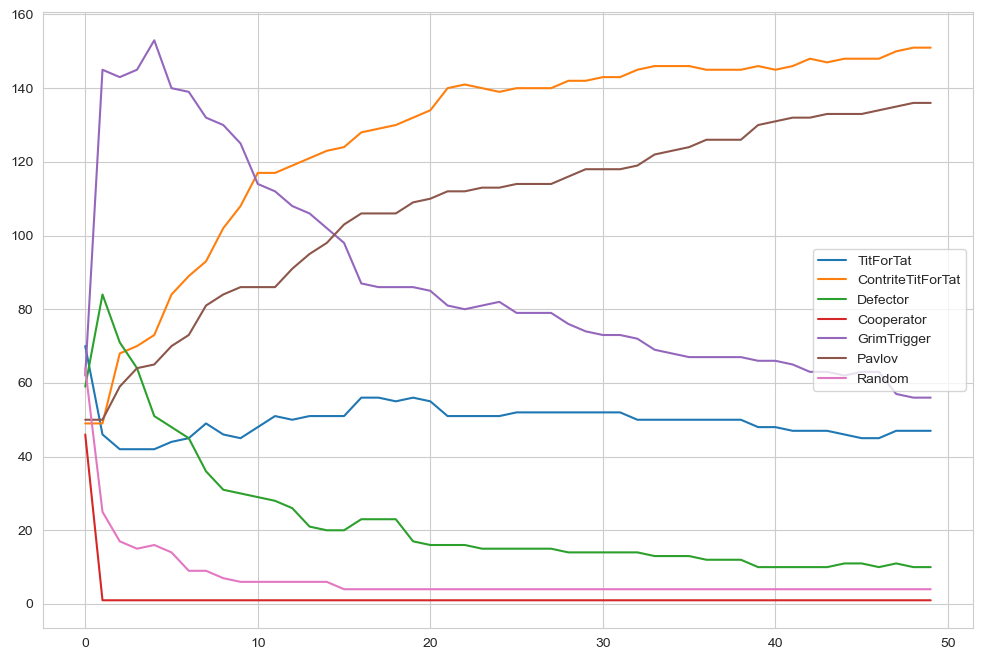

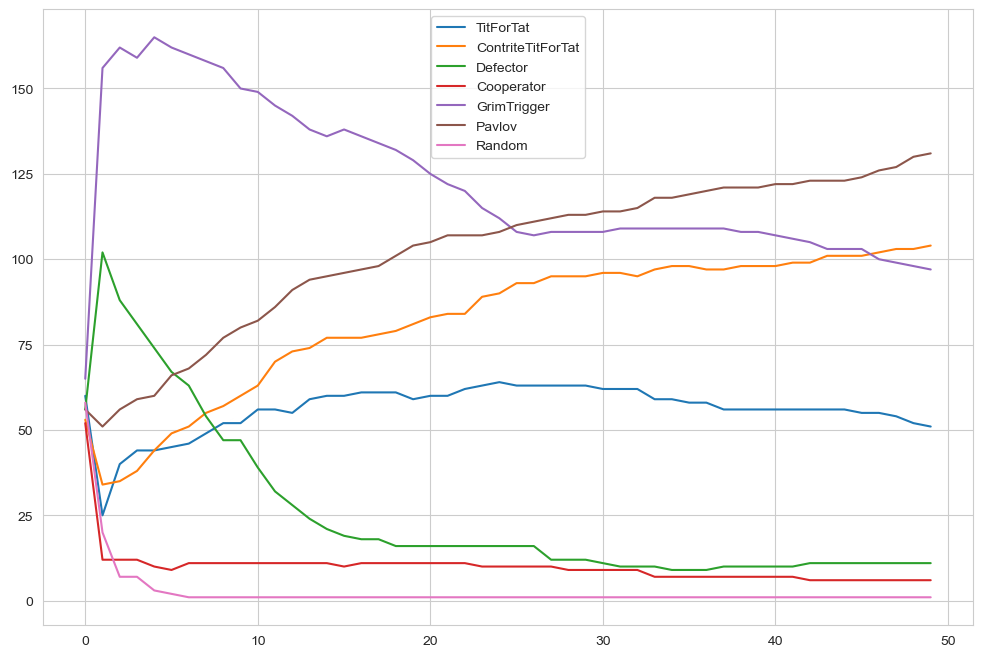

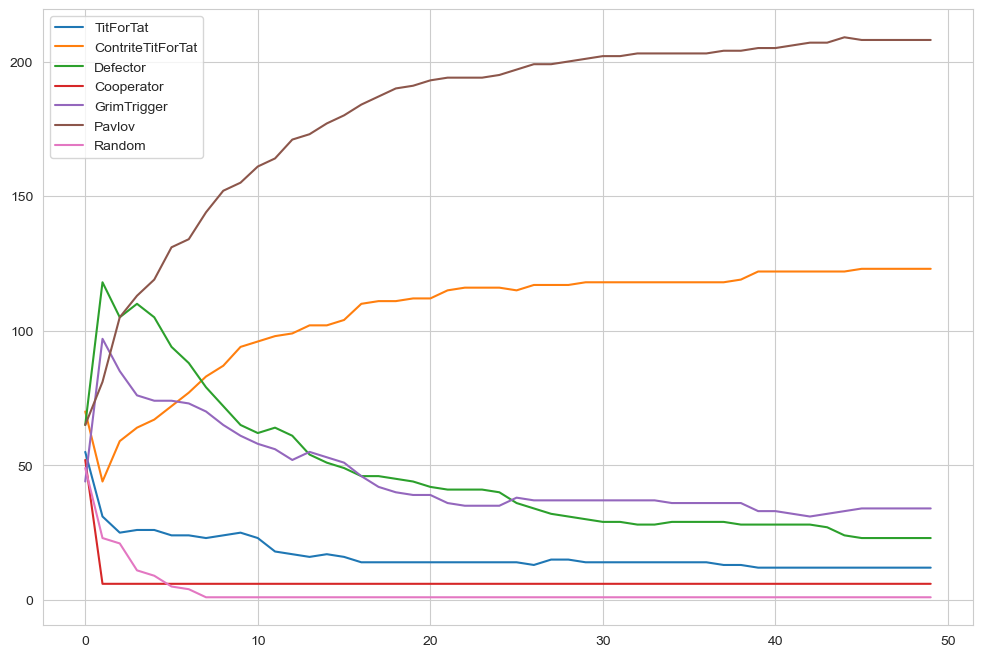

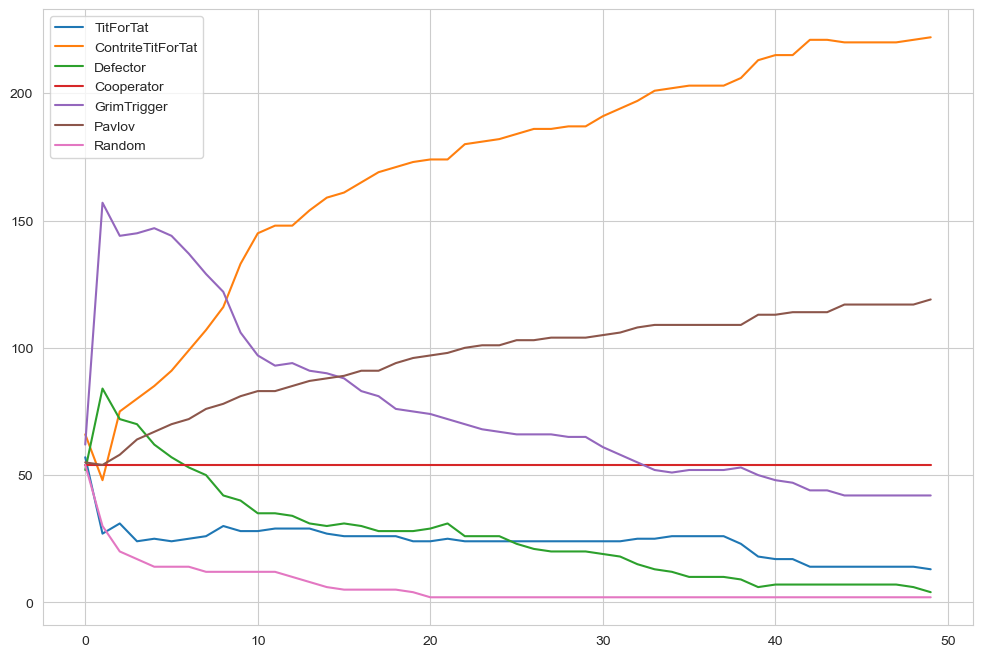

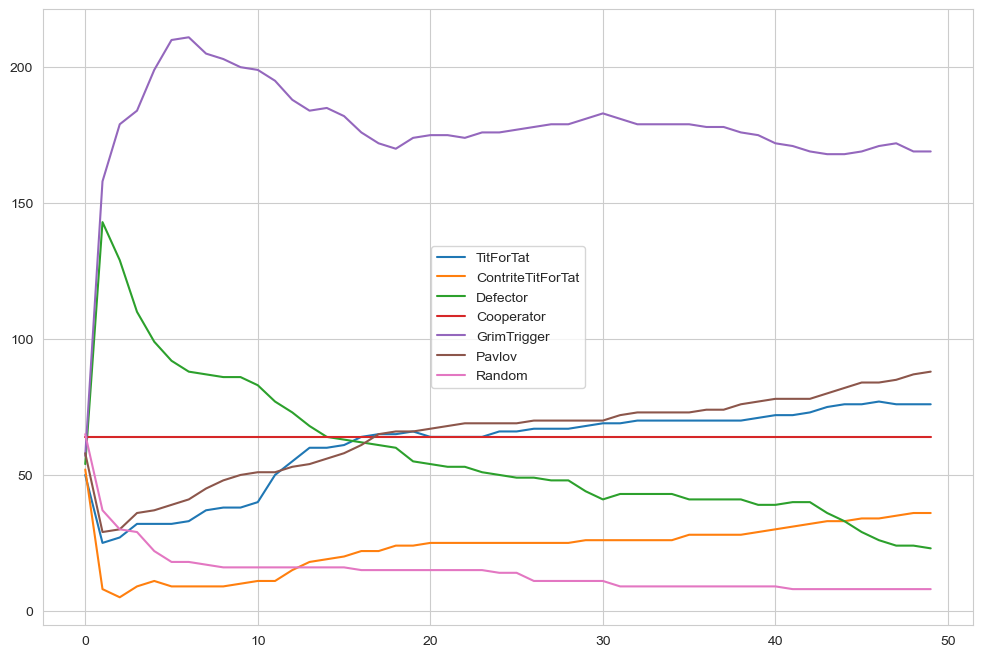

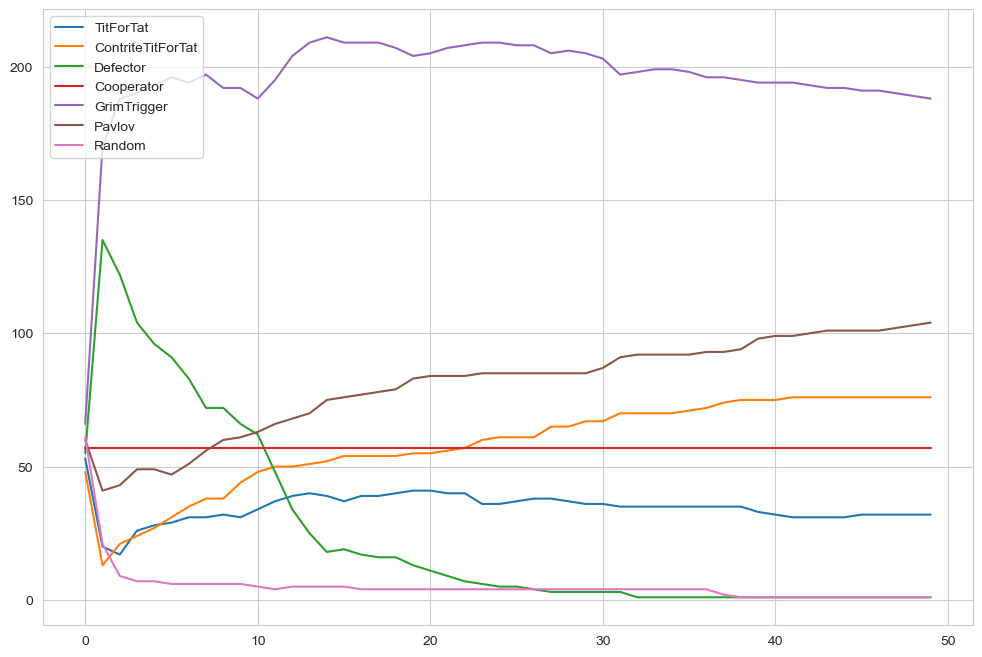

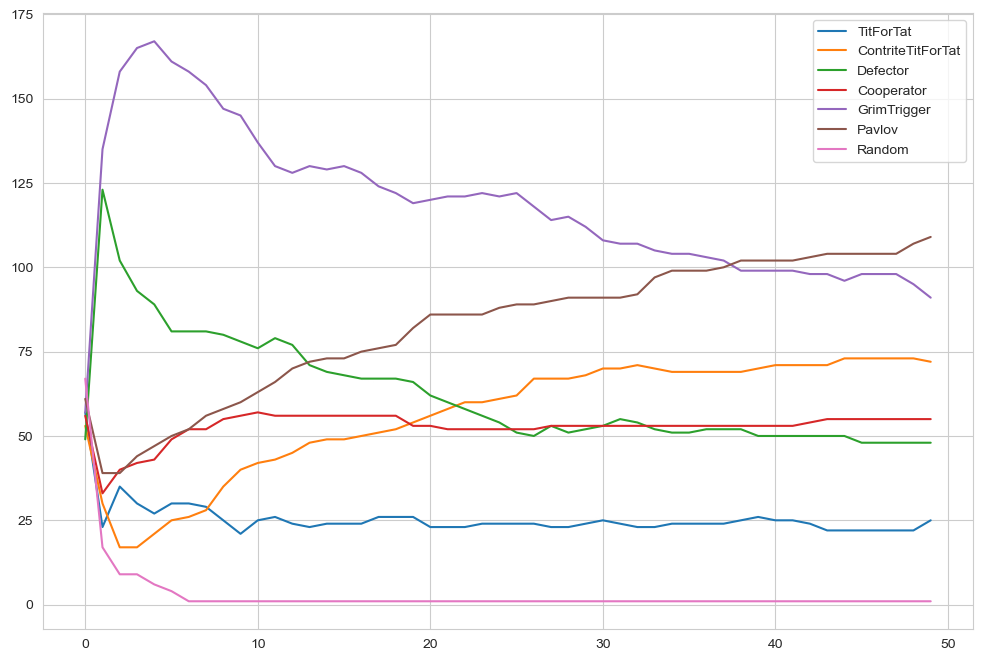

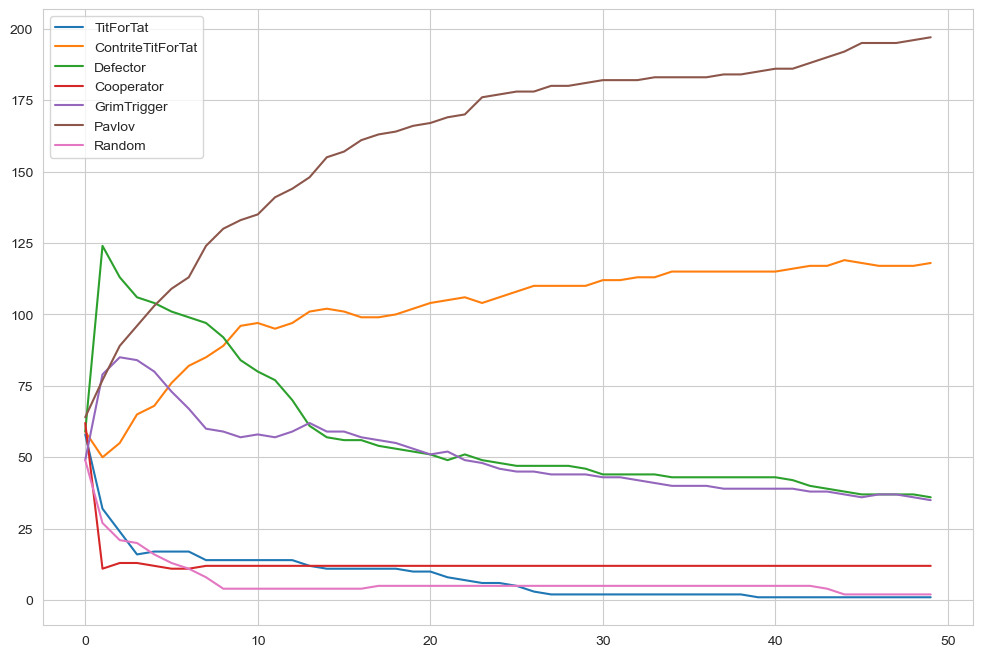

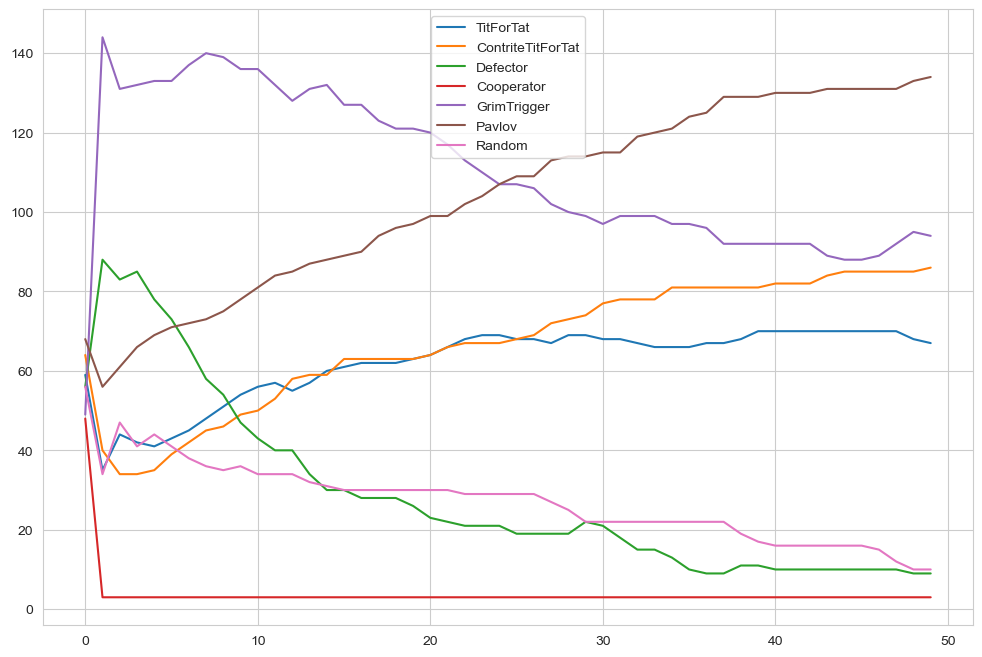

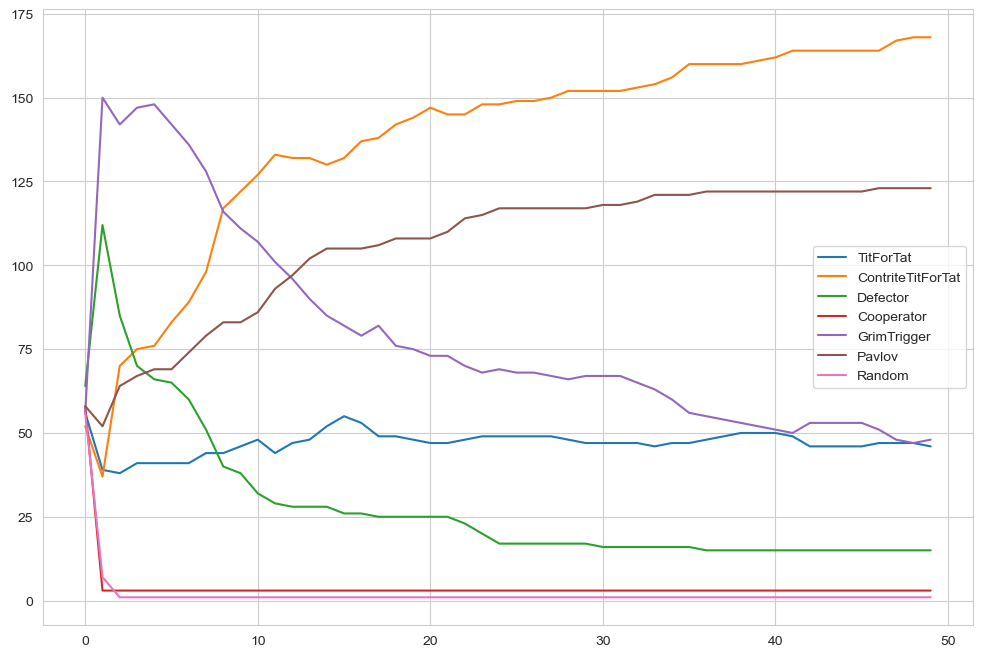

In [7]:
for _ in range(10):
    model = NoisySpatialEvolutionaryAxelrodModel(200)
    for _ in range(50):
        model.step()
    model.datacollector.get_model_vars_dataframe().plot()
    plt.show()